# 06D. Stachastic state transitions

### Mingyang Lu

### 3/7/2024

# SDEs for a toggle switch circuit 

In this section, we will apply the previously described numerical methods to a toggle switch circuit, as described in Part 2A and Part 3. The dynamics of the circuit expression is governed by a two-variable ODE in the case of deterministic analysis. When we consider gene expression noise to the circuit, the system can be described by SDEs. 

\begin{equation}
\begin{cases} \frac{dX}{dt} = g_{X_0} + g_{X1}\frac{1}{1+(Y/Y_0)^{n_Y}} - k_XX + s_X(X,Y)\eta_X(t) \\
              \frac{dY}{dt} = g_{Y_0} + g_{Y1}\frac{1}{1+(X/X_0)^{n_X}} - k_YY + s_Y(X,Y)\eta_Y(t) \tag{1} \end{cases}
\end{equation}

Here, we consider the system with constant noise. Below is the R implementation of the rate equations and the noise terms. We use vectors to represent state variables $(X, Y)$, the derivatives $(\frac{dX}{dt}, \frac{dY}{dt})$, and the noise terms $(s_X(X,Y), s_Y(X,Y))$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def hill_inh(X, X0, n):
    a = (X / X0) ** n
    return 1 / (1 + a)

# Rate equation for toggle switch
def f_ts(t, X, b):
    dX_dt = 10 + 40 * hill_inh(X[1], 100, 4) - 0.1 * X[0]
    dY_dt = 10 + 40 * hill_inh(X[0], 100, 4) - 0.1 * X[1]
    return np.array([dX_dt, dY_dt])

# Constant noise
def noise_ts(t, X, b):
    return b

As the system has constant noise, the Euler-Maruyama method is applied here. 

In [2]:
def SDE_Euler_2D(derivs_2D, noise_2D, X0, t_total, dt, **kwargs):
    """
    An SDE integrator using the Euler method for 2D systems
    :param derivs_2D: function of the derivatives, returns a 2D vector
    :param noise_2D: function of the noise term, returns a 2D vector
    :param X0: initial condition, a 2D vector
    :param t_total: total simulation time
    :param dt: time step size
    :param **kwargs: additional keyworded arguments to derivs_2D and noise_2D functions
    :return: matrix of t & X(t) for all time steps
    """
    t_all = np.arange(0, t_total + dt, dt)
    n_all = len(t_all)
    X_all = np.zeros((n_all, 2))
    X_all[0] = X0
    dW_all = np.random.normal(loc=0, scale=np.sqrt(dt), size=(n_all, 2))

    for i in range(n_all - 1):
        t = t_all[i]
        X = X_all[i]
        dW = dW_all[i]
        X += dt * derivs_2D(t, X, **kwargs) + dW * noise_2D(t, X, **kwargs)
        X_all[i + 1] = np.maximum(0, X)  # Ensure X values are non-negative

    return np.column_stack((t_all, X_all))

Now we perform a stochastic simulation.

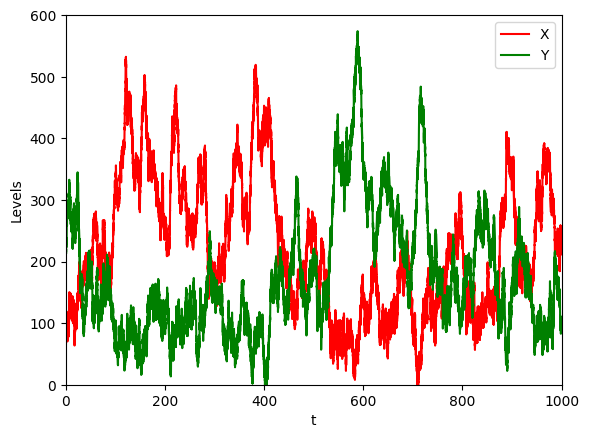

In [3]:
# Set parameters and initial conditions
b = np.array([20, 20])
X_init = np.array([50, 200])

# Set random seed and simulate using SDE_Euler_2D
np.random.seed(1)
results = SDE_Euler_2D(f_ts, noise_ts, X0=X_init, t_total=1000, dt=0.01, b = b)

# Plot the results
plt.plot(results[:, 0], results[:, 1], color='red', label='X')
plt.plot(results[:, 0], results[:, 2], color='green', label='Y')
plt.xlabel('t')
plt.ylabel('Levels')
plt.xlim(0, 1000)
plt.ylim(0, 600)
plt.legend(loc='upper right')
plt.show()

We can also visualize the stochastic trajectory in the phase plane of $X$ and $Y$.

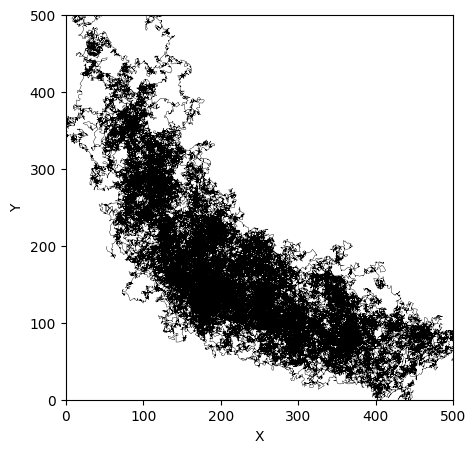

In [4]:
plt.figure(figsize=(5, 5))
plt.plot(results[:, 1], results[:, 2], color='black', linewidth=0.3)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

Similar to the circuit with a self-activating gene, the toggle switch circuit also exhibit bistability. And with sufficient gene expression noise, the circuit can undergo state transitions between the two stable steady states. The state transition happens when $X$ and $Y$ switch the expression levels between the low $X$ high $Y$ state and the high $X$ and low $Y$ state. 

Also see the R version of numerical R part 06D for the calculation of transition rate